In [ ]:
# !pip install tensorflow
# !pip install keras
# !pip install -U segmentation-models

In [21]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image
from tensorflow.keras.metrics import MeanIoU
import pandas as pd

import segmentation_models as sm

# tf.compat.v1.disable_eager_execution() #in case the model gets very slow, may be due to a bug in TF2.0. Uncomment this. 
#https://github.com/tensorflow/tensorflow/issues/33024

#Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

In [47]:
################################################################
#Get an understanding by looking at a few random images and masks 

train_img_dir = "data/Data/train_images/train/"
train_mask_dir = "data/Data/train_masks/train/"

img_list = sorted(os.listdir(train_img_dir))#listing images and masks
msk_list = sorted(os.listdir(train_mask_dir))

num_images = (len(os.listdir(train_img_dir)))#identifying how many'


img_num = random.randint(0, num_images-1)#choose a random image

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)#load the random image
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)
ImArray = np.load(train_mask_dir+msk_list[img_num])
#print((ImArray))
mask_for_plot = Image.fromarray(ImArray*80)
print(train_img_dir+img_list[img_num])
print(train_mask_dir+msk_list[img_num])

#plotting random image
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

################################################################

data/Data/train_images/train/31_Ritterstraße_Sate.png
data/Data/train_masks/train/31_Ritterstraße_Sate.npy


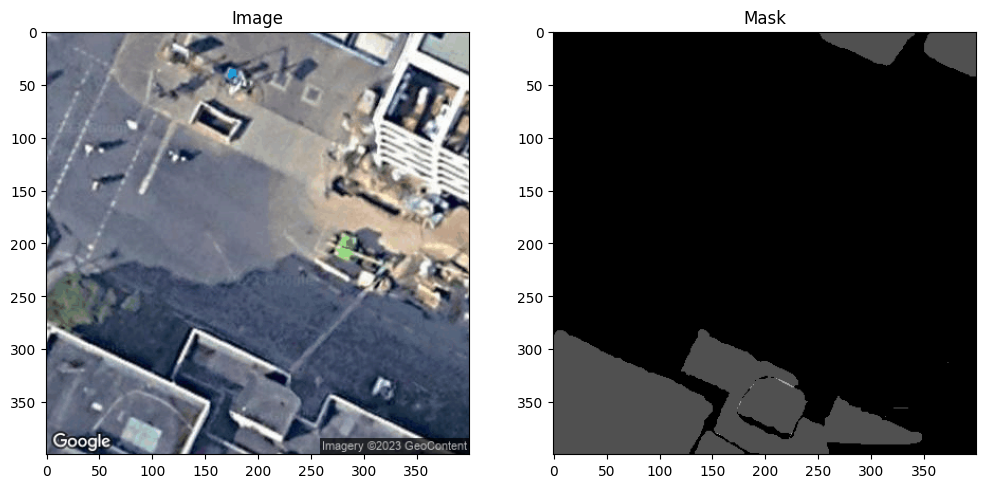

In [66]:
###############################################################

# Define Generator for images and masks so we can read them directly from the drive. 
#CNN parameters defined, seed/ random seed to make sure they same randomess is used, 
#batches size.. amount of figures used(?), classes here also 4 as mapped for the masks
seed=24
batch_size= 16
n_classes=4
# we always scale out data - better, easier to find patterns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical #keras deep learning module 

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'#defining the preprocessing is like ... resnet34
preprocess_input = sm.get_preprocessing(BACKBONE)#loading it 



In [67]:
#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)#apply processing transformation 
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone... preprocess_input is from get_preprocessing from sm segementation
    #Convert mask to one-hot??? -> categorical
    mask = to_categorical(mask, num_class)#from keras
      
    return (img,mask)


In [68]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):#function def from Dr. Sreenivas Bhattiprolu 
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)#tensorflow.keras.preprocessing.image, passing generatort arguments
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)#applying the preprocessing to the data/iamges/masks
        yield (img, mask)

In [69]:
train_img_path = "data/Data/train_images/"
train_mask_path = "data/Data/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=4)#function from before is called for images

In [70]:
val_img_path = "data/Data/val_images/"
val_mask_path = "data/Data/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=4)#function is called for masks 

In [71]:
#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()


Found 47 images belonging to 1 classes.
Found 0 images belonging to 2 classes.


In [64]:
print(y)

[]


In [65]:

for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
###########################################################################
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('data/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('data/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=4


In [ ]:
#############################################################################
#Use transfer learning using pretrained encoder in the U-Net
#(make sure you uncomment the preprocess_input part in the
# preprocess_data function above)
################################################################
#Define the model
# define model
model = sm.Unet(BACKBONE, 
                encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, 
                activation='softmax')
#compiling the model
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
print(model.summary())
print(model.input_shape)

In [ ]:

#Fit the model
#history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=len(X_train) // 16, validation_steps=len(X_train) // 16, epochs=100)
#Train the model. 
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

In [ ]:
##################################################################
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
#####################################################

from keras.models import load_model

model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

In [ ]:
from distutils.sysconfig import get_python_lib
print(get_python_lib())

/Users/robertroskoden/.pyenv/versions/3.11.3/lib/python3.11/site-packages
